# Panama Papers: Discovery of Corruption

* Students: Ilija Gjorgjiev, Gauthier Mueller, Mahmoud Zgolli
* Dataset: Panama Papers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from py2neo import Graph, Node, Relationship
import neo4jupyter
import networkx as nx
import csv, os, sys

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

from pputils import *

neo4jupyter.init_notebook_mode()

%matplotlib inline


<IPython.core.display.Javascript object>

# 2. Load and convert Data

The downloaded dataset file has 5 csv files.

1/ Entity: Offshore company created in a low-tax by an offshore jurisdiction agent.

2/ Officer: Person or company who plays a role in an offshore entity.

3/ Edges : 

4/ Address: A contact postal address.

5/ Intermediary: Intermediar between someone looking for an offshore corporation and an offshore service provider.

In [2]:
#Load Data
panama_entity = pd.read_csv('./Data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
panama_officer = pd.read_csv('./Data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
panama_edges = pd.read_csv("./Data/panama_papers/panama_papers.edges.csv", low_memory=False)
panama_address = pd.read_csv("./Data/panama_papers/panama_papers.nodes.address.csv", low_memory=False)
panama_intermediary = pd.read_csv("./Data/panama_papers/panama_papers.nodes.intermediary.csv", low_memory=False)
fortune_500_comp = pd.read_csv("./Data/fortune_500_companies_US.csv", low_memory=False, encoding='latin-1')

### Gini Vs frequency 

In [3]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
apiIndicator = "SI.POV.GINI"    # This can be changed to any other indicator
source = apiBase+apiIndicator+"?format=csv"
#Import gini index data
giniIndex = pd.read_csv(source)

-0.09082132894651794
0.5722607229416976


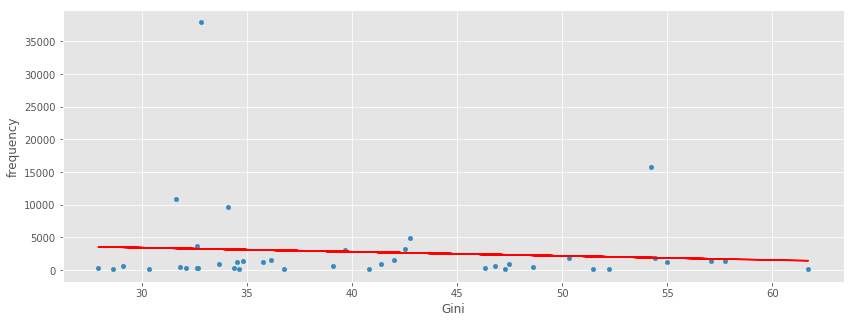

In [4]:
# frequency of the country in the panama dataframe
frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#Gini Data wrangling
lst =[str(x) for x in range(1960,2018)]
gini_index=pd.DataFrame()
gini_index['Country']=giniIndex['Country Name']
gini_index['Gini']=giniIndex[lst].mean(axis=1)    # take the mean over the years 
#merge gini with frequency 
freq_gini = pd.merge(frequency,gini_index,how='inner').dropna()
#only countries existing more than 100 times
freq_gini =freq_gini[freq_gini['frequency'].apply(lambda x: x>100)]
#plot the gini index vs frquency 
freq_gini[['Gini','frequency']].plot(kind='scatter', x='Gini', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_gini['Gini'], freq_gini['frequency'])
plt.plot(freq_gini['Gini'], intercept + slope*freq_gini['Gini'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

### Corruption vs frequency


0.35966314185719567
0.014088757537746235


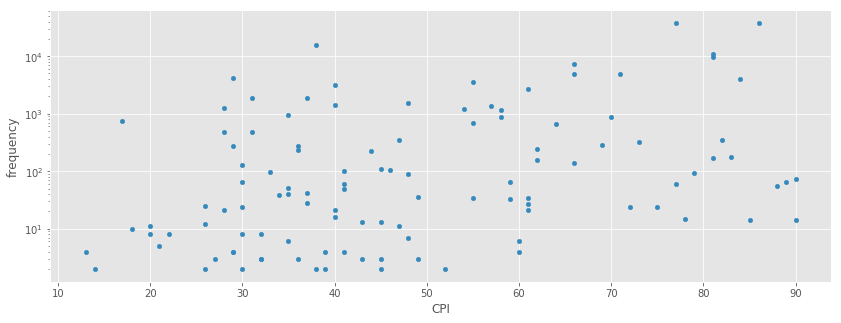

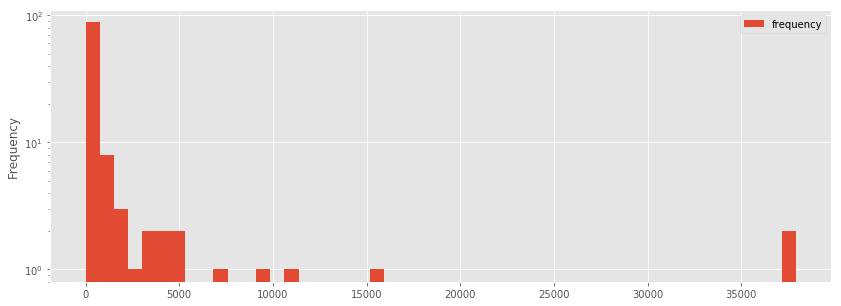

In [91]:
#Import corruption index data
corruption_index = pd.read_csv("./Data/corruption_index.csv", low_memory=False, encoding='latin-1')
#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]
#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')
#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>1)]
#plot the corruption index vs frquency 
freq_corruption[['CPI','frequency']].plot(kind='scatter',logy=True, x='CPI', y='frequency', grid=True,figsize=(14,5))
freq_corruption[['CPI','frequency']].plot(kind='hist',bins=50,logy=True, x='CPI', y='frequency', grid=True,figsize=(14,5))
#slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
#plt.plot(freq_corruption.CPI, intercept + slope*freq_corruption.CPI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

### Frequency vs peace index

-0.22149058890194362
0.15346133577402182


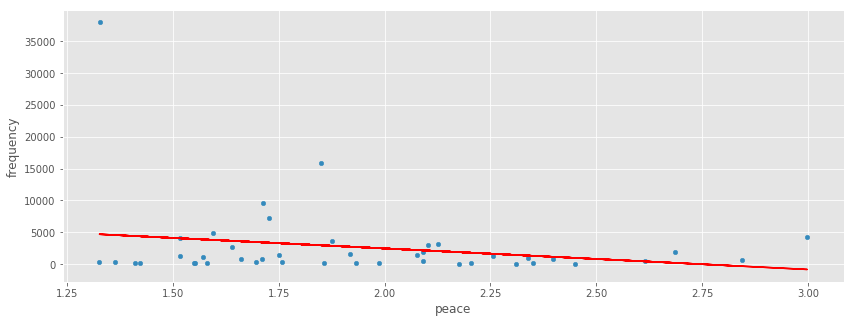

In [73]:
#Import peace index dataset
peace_index = pd.read_csv("./Data/gpi_2008-2016.csv", low_memory=False)
#select the country and the mean of peace index from 2008 to 2016
peace_index=peace_index[['Country','peace']]
#merge peace with frequency 
freq_peace = pd.merge(frequency,peace_index,how='inner')
#only countries existing more than 100 times
freq_peace =freq_peace[freq_peace['frequency'].apply(lambda x: x>100)]
#plot the peace index vs frquency 
freq_peace[['peace','frequency']].plot(kind='scatter', x='peace', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_peace.peace, freq_peace.frequency)
plt.plot(freq_peace.peace, intercept + slope*freq_peace.peace, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

### Foreign direct investment as  % of GDP

0.04979426596527164
0.7482192800398114


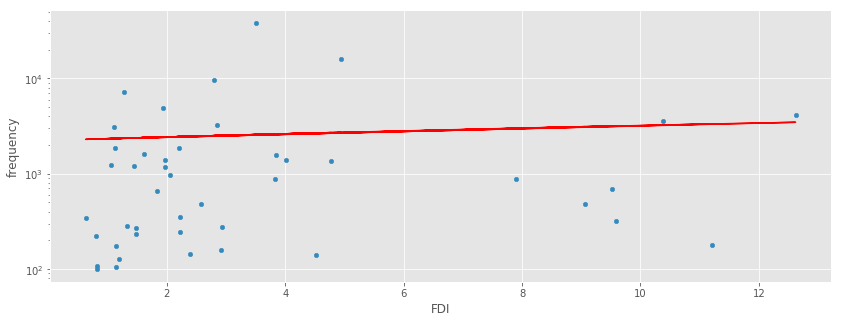

In [70]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
apiIndicator2 = "BX.KLT.DINV.WD.GD.ZS"    # This can be changed to any other indicator
#apiIndicator2 = "BX.GSR.GNFS.CD"    # This can be changed to any other indicator

source2 = apiBase+apiIndicator2+"?format=csv"
#Import gini index data
for_i = pd.read_csv(source2)
#Datawrangling
lst =[str(x) for x in range(1960,2018)]
for_invest=pd.DataFrame()
for_invest['Country']=for_i['Country Name']
for_invest['FDI']=for_i[lst].mean(axis=1) # take the mean over the years 
for_invest['FDI']=pd.to_numeric(for_invest['FDI'])    # take the mean over the years 
#merge gini with frequency 
freq_invest = pd.merge(frequency,for_invest,how='inner').dropna()
#only countries existing more than 100 times
freq_invest =freq_invest[freq_invest['frequency'].apply(lambda x: x>100)]
freq_invest =freq_invest[freq_invest['FDI'].apply(lambda x: x<40)]
#plot the gini index vs frquency 
freq_invest[['FDI','frequency']].plot(kind='scatter',logy=True, x='FDI', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_invest['FDI'], freq_invest['frequency'])
plt.plot(freq_invest['FDI'], intercept + slope*freq_invest['FDI'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

### Insurance and financial services (% of service exports, BoP)


0.35966314185719567
0.014088757537746235


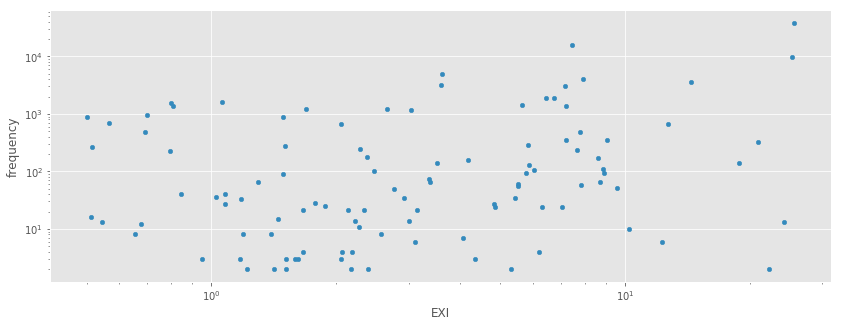

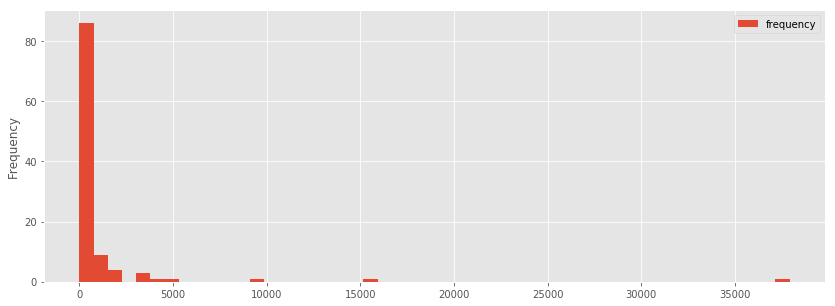

In [89]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
#apiIndicator2 = "BX.KLT.DINV.WD.GD.ZS"    # This can be changed to any other indicator
apiIndicator3 = "BX.GSR.INSF.ZS"    # This can be changed to any other indicator



source3 = apiBase+apiIndicator3+"?format=csv"
#Import gini index data
exp_i = pd.read_csv(source3)
#Datawrangling
lst =[str(x) for x in range(1960,2018)]
exp_invest=pd.DataFrame()
exp_invest['Country']=exp_i['Country Name']
exp_invest['EXI']=exp_i[lst].mean(axis=1) # take the mean over the years 
exp_invest['EXI']=pd.to_numeric(exp_invest['EXI'])    # take the mean over the years 
#merge gini with frequency 
freq_exp = pd.merge(frequency,exp_invest,how='inner').dropna()
freq_exp =freq_exp[freq_exp['frequency'].apply(lambda x: x>1)]
freq_exp =freq_exp[freq_exp['EXI'].apply(lambda x: x<40)]
#plot the gini index vs frquency 
freq_exp[['EXI','frequency']].plot(kind='scatter',loglog=True, x='EXI', y='frequency', grid=True,figsize=(14,5))
freq_exp[['EXI','frequency']].plot(kind='hist',bins=50, x='EXI', y='frequency', grid=True,figsize=(14,5))
#slope, intercept, r_value, p_value, std_err = stats.linregress(freq_exp['EXI'], freq_exp['frequency'])
#plt.plot(freq_exp['EXI'], intercept + slope*freq_exp['EXI'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

### Service exports (BoP, current US dolar)

0.35966314185719567
0.014088757537746235


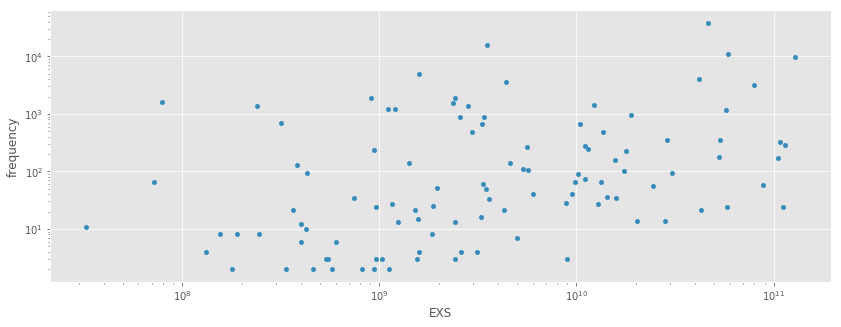

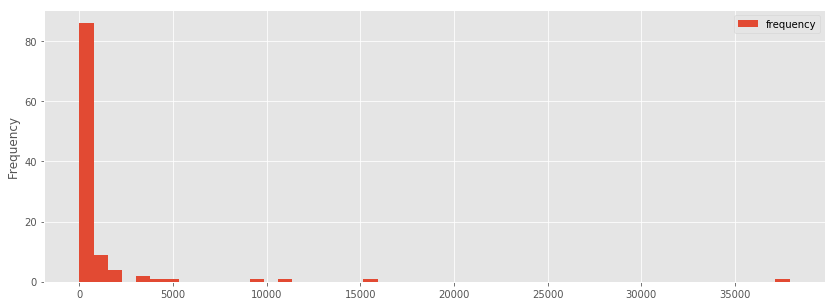

In [93]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
apiIndicator4 = "BX.GSR.NFSV.CD"    # This can be changed to any other indicator
source4 = apiBase+apiIndicator4+"?format=csv"
#Import gini index data
exp_s = pd.read_csv(source4)
#Datawrangling
lst =[str(x) for x in range(1960,2018)]
exp_service=pd.DataFrame()
exp_service['Country']=exp_s['Country Name']
exp_service['EXS']=exp_s[lst].mean(axis=1) # take the mean over the years 
exp_service['EXS']=pd.to_numeric(exp_service['EXS'])    # take the mean over the years 
#merge gini with frequency 
freq_service = pd.merge(frequency,exp_service,how='inner').dropna()
freq_service =freq_service[freq_service['frequency'].apply(lambda x: x>1)]
freq_service =freq_service[freq_service['EXS'].apply(lambda x: x< 2e11)]
#plot the gini index vs frquency 
freq_service[['EXS','frequency']].plot(kind='scatter',loglog=True, x='EXS', y='frequency', grid=True,figsize=(14,5))
#slope, intercept, r_value, p_value, std_err = stats.linregress(freq_service['EXS'], freq_service['frequency'])
#plt.loglog(freq_service['EXS'], intercept + slope*freq_service['EXS'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## Corruption VS Services 

0.35966314185719567
0.014088757537746235
59.617990430076304


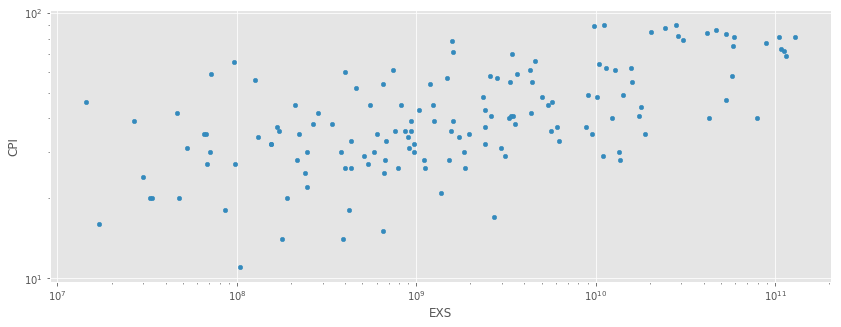

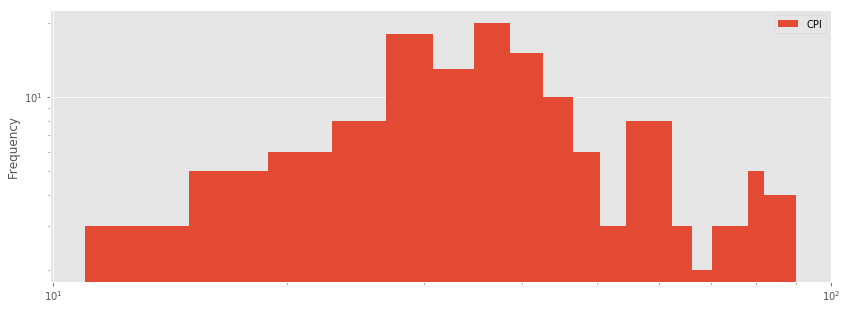

In [97]:
corrup_service = pd.merge(corr_index,exp_service,how='inner').dropna()
#plot the gini index vs frquency 
corrup_service[['CPI','EXS']].plot(kind='scatter', x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
corrup_service[['CPI','EXS']].plot(kind='hist',bins=20, x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
#corrup_service =corrup_service[corrup_service['CPI'].apply(lambda x: x>0)]
#corrup_service =corrup_service[corrup_service['EXS'].apply(lambda x: x< 10e11)]
#slope, intercept, r_value, p_value, std_err = stats.linregress(corrup_service['EXS'], corrup_service['CPI'])
#plt.plot(corrup_service['EXS'], intercept + slope*corrup_service['EXS'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)
print(std_err)

### Humand D I vs frequency 

0.3112409278414904
0.027799394405528935


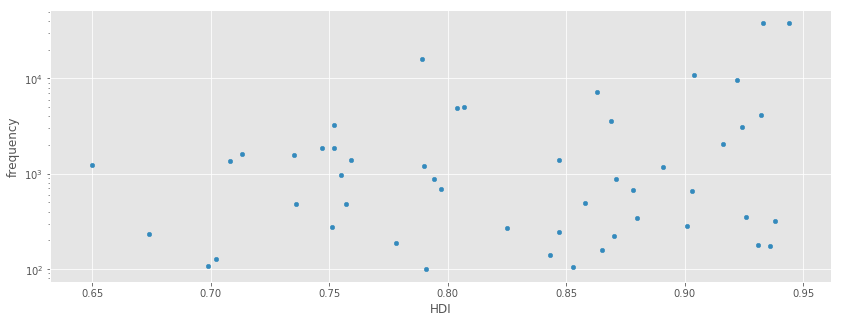

In [69]:
#Import HDi index dataset
dev = pd.read_csv("./Data/2018_Statistical_Annex_Table_1.csv", encoding='latin-1',header=6)
#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x>100)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
#slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

In [ ]:
#Convert Date/Time Values
panama_entity['incorporation_date'] = pd.to_datetime(panama_entity['incorporation_date'])
panama_entity['inactivation_date'] = pd.to_datetime(panama_entity['inactivation_date'])
#panama_entity['struck_off_date'] = pd.to_datetime(panama_entity['struck_off_date'])
panama_entity["closed_date"] = pd.to_datetime(panama_entity["closed_date"])

# 3. Explore data

In [ ]:
panama_officer.head(20)

## 3.1 Panama entity
We First explore the entity dataset to undersand it a little bit 

In [ ]:
print(panama_entity.shape)
panama_entity.head(2)

## 3.2 Dataset analysis


### 3.2.1 General information 

We start by getting the genral informations abot or dataset such as :

- The nationality of the Top 10 present offshore companies: We can see that Switzerlnd and Hongkong are by far the most present firm nationalities. All the present countries are developped ones.

- The nationality of the Top 15 present offshore juridiction firms: This a log plot, The british virging islands are the most preset juridiction firms.

- The evoluution of number of entities along the years: It all started around 1975 and the nmber increased exponantially. With 2 major crises in 2003 and 2010. 

- The  Top 10 present relation types:This is also a log plot, The shareholders are the most preset relations .


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
panama_entity["countries"].value_counts().head(10).plot.bar(title="Top 10 Countries", ax=axes[0,0])
ax=pd.DataFrame(panama_entity['incorporation_date'].dropna().dt.year.astype(int).value_counts()).sort_index().plot.line(title='number of entites evolution',ax= axes[0,1])
panama_entity["jurisdiction_description"].value_counts().head(15).plot.bar(log = True, title="Top 15 Jurisdiction", ax = axes[1,0])
panama_edges["link"].value_counts().head(10).plot.bar(log=True, title = "Top 10 Relation Type", ax = axes[1,1])
ax.set_xlabel('Year')
ax.set_ylabel('Nmber of entited')
plt.tight_layout()
plt.show()

### 3.2.1 Top 10 related entities

In [ ]:
#Get Top 10 Entities that are in Relation
df = panama_edges.groupby('START_ID')['TYPE'].value_counts().to_frame()
df.columns = ["Number of Relations"]
df = df.sort_values(by=["Number of Relations"], ascending = False)
node_ids = df.head(10).copy()
node_ids.reset_index(inplace=True)
names = []
relations = []
#Search for them in Officers, Intermediares or Entities
for i in range(0, 10):
    name = ""
    relations.append(node_ids.loc[i, "TYPE"])
    ID = node_ids.loc[i, "START_ID"]
    if ID in panama_entity["node_id"].values:
        name = panama_entity[panama_entity["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_intermediary["node_id"].values:
        name = panama_intermediary[panama_intermediary["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_officer["node_id"].values:
        name = (panama_officer[panama_officer["node_id"] == ID]["name"])
        names.append(name)
    else:
        name = panama_address[panama_address["node_id"] == ID]["address"]
        names.append(name)

node_ids["Entity Name"] = pd.Series(names)
node_ids.plot.bar(x = "Entity Name", y = "Number of Relations", title = "Top 10 Entities that are in Relation")


In [ ]:
#As we can see most of them are intermediaries.
node_ids.head(10) 

In [ ]:
#Top 10 Statuses of Entities
panama_entity["status"].value_counts().plot.bar(log=True)

# Creation of The Graph

First we create the full graph. The edges are directed connections, as they give out information about who is shareholder of, intermediate of, director of, etc. Nodes can be any of addresses, entities, intermediates or officers. This is due to the fact that an entity should have a legal address, and then intermediaries or officers can be person, companies, foundations, etc.

In [ ]:
# create graph
G = nx.DiGraph()

for n,row in panama_address.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in panama_entity.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in panama_intermediary.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in panama_officer.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in panama_edges.iterrows():b
    G.add_edge(row['START_ID'], row['END_ID'], rel_type=row.TYPE, details=row.to_dict())

In [ ]:
nx.write_adjlist(G,"pp_graph.adjlist")

### Exploring connections of Fortune 500 Companies with Panama Papers

In this subsection we will explore the connections of Fortune 500 Companies with the Panama Papers. 

In [ ]:
#Explore Forture 500 companies, if they are somehow connected to offshore companies.
fortune_500_comp.head(2)

In [ ]:
fortune_500_names = fortune_500_comp["Company Name"].values
fortune_500_names = [x.lower() for x in fortune_500_names]

#Check in Entities
for name in fortune_500_names:
    p = panama_entity[(panama_entity["country_codes"] == "USA") & (panama_entity["name"].str.lower().str.contains(name, na=False))]["name"]
    if not p.empty:
        print("Fortune 500 Name:", name)
        print(p)



* It is actually difficult to understand if these companies are somehow correlated or not from the data that we have. But we found that there is an entity under the name TESLA Foundation and MOSAIC INTERNATIONAL INC. registered under USA country code, which maybe correlated to TESLA or MOSAIC, that is why we decided to dig up a little bit on that.

In [ ]:
#Tesla Foundation and MOSAIC INTERNATIONAL INC.
panama_entity[panama_entity["name"].isin(["TESLA FOUNDATION", "MOSAIC INTERNATIONAL INC."])]

In [ ]:
#Unfortunatelly the Entity is not connected to anything.
teslaGraph = G.subgraph(nx.shortest_path(G, 10168981))
plot_graph(teslaGraph, figsize=(15,12), label_edges=True)

In [ ]:
#Unfortunatelly the Entity is not connected to anything.
mosaicGraph = G.subgraph(nx.shortest_path(G, 10065968))
plot_graph(mosaicGraph, figsize=(15,12), label_edges=True)

### Network of King Salman bin Abdulaziz bin Abdulrahman Al Saud - King of Saudi Arabia
In this subsection we will explore the connection of big player name that was found in the panama papers. We will expore the network of King of Saudi Arabia - Salman bin Abdulaziz bin Abdulrahman Al Saud. 

In [ ]:
#Explore Network for Tax Evasion Comapnies that are surronded around King Salman bin Abdulaziz bin Abdulrahman Al Saud
kingSaudiArabia = "King Salman bin Abdulaziz bin Abdulrahman Al Saud"

#Check if he actually exists in the data.
panama_officer[panama_officer["name"] == kingSaudiArabia]

In [ ]:
#Create a subgraph(connected component, which will shows with what nodes does the king interact) by BFS
kingGraph = G.subgraph(nx.shortest_path(G, 15004501))
plot_graph(kingGraph, figsize=(15,12), label_edges=True)

As we can see the King is connected to a couple of companies all having almost the same name(probably are the same company) which are being officers, the company address is in Luxembourg. these companies are then connected to actual offshore entities. We can see that this SAFASON CORPORATION SPF is connected to various other entties VERSE DEVELOPMENT CORP, CRASSUS LIMITED, PARK PROPERTY LIMITED, CRASSUS LIMITED.

In [ ]:
#Expore VERSE DEVELOPENT CORP, 
listOfEntities = ["VERSE DEVELOPMENT CORP.", "PARK PROPERTY LIMITED", "INROW CORPORATION", "CRASSUS LIMITED"] 
display(panama_entity[panama_entity["name"].isin(listOfEntities)])

We can see that Verse Development Corp. was incorporated in 1991 in Panama, under the country Jordan, in fact all of the companies are under country Jordan. All of the entities are a still activate, and they are residing in 2 jurisdictions Panama and British Virgin Islands.

## Milestone 3

For milestone 3 we are going to finish answering the questions we chose to keep. For the correlation between social-economical condition and tax evasion we are going to use additional information, Human Development Index, Global Peace Index and Corruption Perception Index. 
Next, we are going to improve the visualization of the data by presenting a data story about the correlation between countries and shells. 

# 4. References

[1] https://github.com/Roussaky/ada-EPFL/blob/master/project/project_notebook.ipynb

[2] https://github.com/REDeLapp/Panama-Papers-Network-Analysis

[3] https://github.com/amaboura/panama-papers-dataset-2016